In [34]:
import pickle
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest


import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
df = pd.read_excel('Data/churn.xlsx')

In [5]:
var_disc = [v for v in df.columns if v[:2]=='C_']
var_cont = [v for v in df.columns if v[:2]=='V_']

for v in var_disc:
    df[v] = (df[v]=='Yes').astype(int)

In [6]:
df.head()

,V_ACCT_LGHT,C_IP,C_VMP,V_N_VM_MESS,V_T_DAY_CHG,V_T_EVE_CALLS,V_T_EVE_CHG,V_T_NIG_CALLS,V_T_NIG_CHG,V_T_INT_CALLS,V_T_INT_CHG,V_CS_CALLS,TARGET,ID
0,128,0,1,25,45.07,99,16.78,91,11.01,3,2.70,1,0,1
1,107,0,1,26,27.47,103,16.62,103,11.45,3,3.70,1,0,2
2,137,0,0,0,41.38,110,10.30,104,7.32,5,3.29,0,0,3
3,65,0,0,0,21.95,83,19.42,111,9.40,6,3.43,4,1,11
4,168,0,0,0,21.90,71,8.92,128,6.35,2,3.02,1,0,13


In [7]:
X = df[var_cont].copy()

In [8]:
scaler = StandardScaler()
scaler.fit(X)
Xs = pd.DataFrame(scaler.transform(X),columns=X.columns)

In [10]:
Xs.head()

,V_ACCT_LGHT,V_N_VM_MESS,V_T_DAY_CHG,V_T_EVE_CALLS,V_T_EVE_CHG,V_T_NIG_CALLS,V_T_NIG_CHG,V_T_INT_CALLS,V_T_INT_CHG,V_CS_CALLS
0,0.717781,1.288203,1.683222,-0.066296,-0.081298,-0.499412,0.930588,-0.634220,-0.115292,-0.429509
1,0.158812,1.363123,-0.356459,0.148504,-0.120873,0.149758,1.136944,-0.634220,1.345746,-0.429509
2,0.957339,-0.584815,1.255584,0.524405,-1.684052,0.203855,-0.799995,0.244341,0.746720,-1.218398
3,-0.959125,-0.584815,-0.996177,-0.925498,0.571675,0.582538,0.175510,0.683622,0.951266,1.937157
4,1.782483,-0.584815,-1.001971,-1.569899,-2.025379,1.502196,-1.254917,-1.073501,0.352240,-0.429509


In [20]:
pca = PCA(n_components=2)
pca.fit(Xs)
Xp = pd.DataFrame(pca.transform(Xs),columns=['p1','p2'])

In [18]:
pca.explained_variance_ratio_.cumsum()

array([0.10674718, 0.21214068])

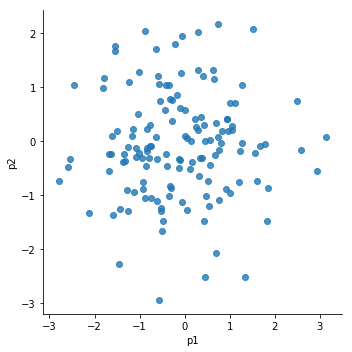

In [22]:
sns.lmplot(data=Xp.sample(frac=0.05),x='p1',y='p2',fit_reg=False)

In [23]:
scaler = MinMaxScaler()
scaler.fit(X)
Xs = pd.DataFrame(scaler.transform(X),columns=X.columns)

In [24]:
lst_in = []
for k in range(2,10):
    cl = KMeans(n_clusters=k)
    cl.fit(X)
    lst_in.append(cl.inertia_)

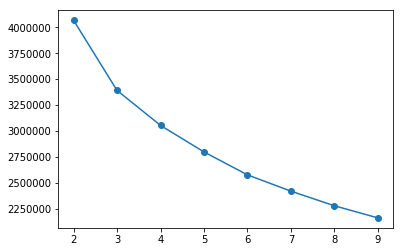

In [28]:
plt.plot(range(2,10),lst_in,marker='o')

In [29]:
cl = GaussianMixture(n_components=3)

In [31]:
cl.fit(Xs)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=3, n_init=1, precisions_init=None,
        random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [32]:
df['cl'] = cl.predict(Xs)

In [33]:
df.cl.value_counts(normalize=True)

1    0.460550
0    0.270261
2    0.269190
Name: cl, dtype: float64

In [35]:
sk = SelectKBest(k=3)

In [36]:
sk.fit(Xs,df[['cl']])

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:526: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python2.7/dist-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


SelectKBest(k=3, score_func=<function f_classif at 0x7f821e6ca230>)

In [40]:
aux = df[[a for a,b in zip(Xs.columns,sk.get_support()) if b]+['cl']].copy()

In [44]:
aux.groupby('cl').mean().to_clipboard()

/usr/lib/python2.7/dist-packages/gtk-2.0/gtk/__init__.py:127: RuntimeWarning: PyOS_InputHook is not available for interactive use of PyGTK
  set_interactive(1)


In [43]:
aux.mean()

V_ACCT_LGHT    101.033559
V_N_VM_MESS      7.805784
V_CS_CALLS       1.544448
cl               0.998929
dtype: float64

In [45]:
aux = df[['cl','TARGET','ID']].copy()

In [47]:
aux.pivot_table(aggfunc='count',columns='TARGET',index='cl',values='ID',fill_value=0).to_clipboard()